# kCCA implementation

In [7]:
import numpy as np
from scipy import linalg
from numpy import matlib

N = 100
reg = 0.00001
sigma = 1
c = 10

np.random.seed(29)

In [8]:
def make_data(kernel):
    # # # Define two latent variables (number of samples x 1)
    latvar1 = np.random.randn(N,)
    latvar2 = np.random.randn(N,)
    
    # # # Define independent components for each dataset (number of observations x dataset dimensions)
    indep1 = np.random.randn(N, 4)
    indep2 = np.random.randn(N, 5)
    
    if kernel == "linear":
        x = 0.25*indep1 + 0.75*np.vstack((latvar1, latvar2, latvar1, latvar2)).T
        y = 0.25*indep2 + 0.75*np.vstack((latvar1, latvar2, latvar1, latvar2, latvar1)).T
        
        return x,y
    
    elif kernel == "poly":
        x = 0.25*indep1 + 0.75*np.vstack((latvar1**2, latvar2**2, latvar1**2, latvar2**2)).T
        y = 0.25*indep2 + 0.75*np.vstack((latvar1, latvar2, latvar1, latvar2, latvar1)).T
        
        return x,y
    
    elif kernel == "gaussian":
        t = np.random.uniform(-np.pi, np.pi, N)
        e1 = np.random.normal(0, 0.05, (N,2))
        e2 = np.random.normal(0, 0.05, (N,2))
        
        x = np.zeros((N,2))
        x[:,0] = t
        x[:,1] = np.sin(3*t)
        x += e1
        
        y = np.zeros((N,2))
        y[:,0] = np.exp(t/4)*np.cos(2*t)
        y[:,1] = np.exp(t/4)*np.sin(2*t)
        y += e2
        
        return x,y
        
def center_norm(x):
    x = x - np.matlib.repmat(np.mean(x, axis=0), N, 1)
    return x@np.sqrt(np.diag(np.divide(1,np.diag(np.transpose(x)@x))))

def make_kernel(x, kernel, par1, par2):
    N0 = np.eye(N)-1/N*np.ones((N,N))
    
    #linear kernel
    if kernel == "linear":
        return N0@(x@x.T + par1)@N0
    
    #polynomial kernel
    elif kernel == "poly":
        return N0@(x@x.T + par2)**par1@N0
    
    #gaussian kernel
    elif kernel == "gaussian":
        norms1 = np.sum(np.square(x),axis=1)[np.newaxis].T
        norms2 = np.sum(np.square(x),axis=1)
        
        mat1 = np.matlib.repmat(norms1,1,N)
        mat2 = np.matlib.repmat(norms2,N,1)
        
        distmat = mat1 + mat2 - 2*x@(x.conj().T)
        return N0@np.exp(-distmat/(2*par1**2))@N0

def fit(x, y, kernel, par1, par2):
    
    x = center_norm(x)
    y = center_norm(y)
    
    Kx = make_kernel(x, kernel, par1, par2)
    Ky = make_kernel(y, kernel, par1, par2)

    I = np.eye(N)
    Z = np.zeros((N,N))
    dim = min(x.shape[1],y.shape[1])
    
    # Solving eigenvalue problem
    R = 0.5*np.r_[np.c_[Kx, Ky], np.c_[Kx, Ky]]
    D = np.r_[np.c_[Kx+reg*I, Z],np.c_[Z, Ky+reg*I]]
    
    ###### make more efficient. limit betasss to dim
    betas = linalg.eig(R,D)[0] #eigenvalues
    alphas = linalg.eig(R,D)[1] #right eigenvectors
    betass = np.sort(np.real(np.diag(betas)))
    betasss = np.sum(betass, axis=1)
    ind = np.argsort(np.sum(np.diag(betas), axis=0), axis=0)
    
    perm_mat = np.zeros((len(ind), len(ind)))
    
    for idx, i in enumerate(ind):
        perm_mat[idx, i] = 1
    
    alphass = np.real(np.dot(alphas, perm_mat)/np.linalg.norm(alphas))
    
    
    # weights
    weight1 = alphass[:N,:dim] #dim can be changed to user input if they want less
    weight2 = alphass[N:,:dim]
    
    return weight1, weight2, betasss

def transform(x, y, weight1, weight2, kernel, par1, par2):
    x = center_norm(x)
    y = center_norm(y)
    
    #### do we need to make kernel or can we just apply weights to normal data
    Kx = make_kernel(x, kernel, par1, par2)
    Ky = make_kernel(y, kernel, par1, par2)
    
    comp1 = []
    comp2 = []
    
    for i in range(weight1.shape[1]):
        comp1.append(Kx@weight1[:,i])
        comp2.append(Ky@weight2[:,i])
        
    comp1 = [l*(-10**18) for l in comp1]
    comp2 = [l*10**18 for l in comp2]
    return comp1, comp2

def fit_transform(Kx,Ky):
    weight1, weight2, betasss = fit(Kx,Ky)
    comp1, comp2 = transform(Kx, Ky, weight1, weight2)
    return comp1, comp2

In [9]:
# Linear kernel implementation
x,y = make_data('linear')

weight1, weight2, betasss = fit(x,y, 'linear',5,10)

comp1, comp2 = transform(x, y, weight1, weight2, 'linear',5,10)

0.984324583256028 0.9930434877249144


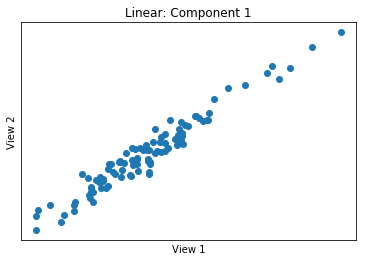

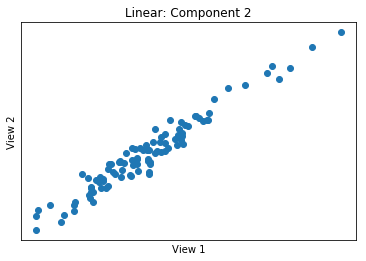

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline  

fig = plt.figure()
plt.scatter(comp1[0], comp2[0])
plt.title('Linear: Component 1')
plt.xlabel('View 1')
plt.ylabel('View 2')
plt.xticks([])
plt.yticks([])

fig = plt.figure()
plt.scatter(comp1[1], comp2[1])
plt.title('Linear: Component 2')
plt.xlabel('View 1')
plt.ylabel('View 2')
plt.xticks([])
plt.yticks([])

print(betasss[0],betasss[1])

In [11]:
# Polynomial kernel implementation
x,y = make_data('poly')

weight1, weight2, betasss = fit(x,y, 'poly',2,10)

comp1, comp2 = transform(x, y, weight1, weight2, 'poly',2,10)

0.984324583256028 0.9930434877249144


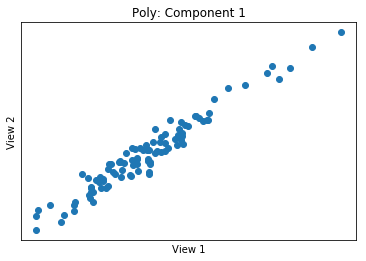

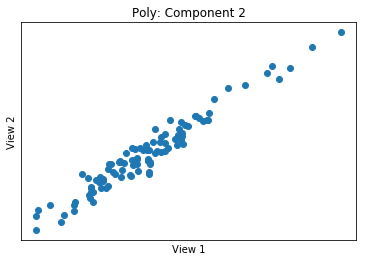

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline  

fig = plt.figure()
plt.scatter(comp1[0], comp2[0])
plt.title('Poly: Component 1')
plt.xlabel('View 1')
plt.ylabel('View 2')
plt.xticks([])
plt.yticks([])

fig = plt.figure()
plt.scatter(comp1[1], comp2[1])
plt.title('Poly: Component 2')
plt.xlabel('View 1')
plt.ylabel('View 2')
plt.xticks([])
plt.yticks([])

print(betasss[0],betasss[1])

In [20]:
# Polynomial kernel implementation
x,y = make_data('gaussian')

weight1, weight2, betasss = fit(x,y, 'gaussian',1,10)

comp1, comp2 = transform(x, y, weight1, weight2, 'gaussian',1,10)

0.9974882924475025 0.9770556461394594


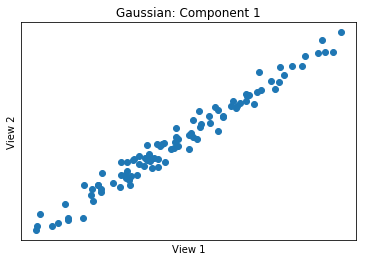

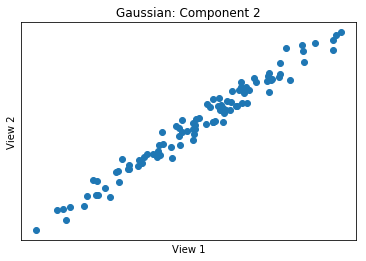

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline  

fig = plt.figure()
plt.scatter(comp1[0], comp2[0])
plt.title('Gaussian: Component 1')
plt.xlabel('View 1')
plt.ylabel('View 2')
plt.xticks([])
plt.yticks([])

fig = plt.figure()
plt.scatter(comp1[1], comp2[1])
plt.title('Gaussian: Component 2')
plt.xlabel('View 1')
plt.ylabel('View 2')
plt.xticks([])
plt.yticks([])

print(betasss[0],betasss[1])